# Plot the inputs used for the density model

In [2]:

%matplotlib inline

import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from theano import shared
from theano import tensor as tt


#sns.set()
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.labelsize'] = 'large'


/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Our model functions
def double_tanh_pm(beta, z):
    """
    Double-tanh function that accepts PyMC3 objects instead of numpy arrays
    """
    fac1 = (z+beta[2])/beta[3]
    fac2 = (z+beta[2]+beta[4])/beta[5]
    
    return beta[0] - beta[1]*( pm.math.tanh(fac1)
                + pm.math.tanh(fac2))

def double_tanh(beta, z):
    
    return beta[0] - beta[1]*(np.tanh((z+beta[2])/beta[3])
                + np.tanh((z+beta[2]+beta[4])/beta[5]))

def linear(beta_s, z):
    
    result = beta_s[0] + beta_s[1] * z
    return result
    

In [4]:
from datetime import datetime
# Load some density data

def convert_time(tt):
    try:
        dt= datetime.strptime(tt, '%Y-%m-%dT%H:%M:%S')
    except:
        dt= datetime.strptime(tt, '%Y-%m-%d %H:%M')
    return dt
def read_rho_csv(csvfile,start=20,end=-10):
    # Reads into a dataframe object
    df = pd.read_csv(csvfile, index_col=0, sep=', ', parse_dates=['Time'], date_parser=convert_time)

    depths= np.array([float(ii) for ii in df.columns.values])
    rho_obs_2d = df[start:end].values.astype(float)
    time = df.index[start:end]
    return depths, rho_obs_2d, time

#df.index[0]

In [5]:
#csvfile = '/home/suntans/Share/ARCHub/DATA/FIELD/IMOS/IMOS_Density_KIM200_2013_a.csv'

# Shell Crux Data
csvfile1 = '/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/Crux_KP150_Phs1_Density_lowpass.csv'
csvfile2 = '/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/Crux_KP150_Phs2_Density_lowpass.csv'
zmin = -252.5
site = 'Crux'

# IMOS Data
csvfile1 = '/home/suntans/Share/ARCHub/DATA/FIELD/IMOS/IMOS_Density_KIM200_2013_b.csv'
csvfile2 = '/home/suntans/Share/ARCHub/DATA/FIELD/IMOS/IMOS_Density_KIM200_2014_a.csv'
zmin = -202.5
site = 'KIM200'

depths1, rho1, time1 = read_rho_csv(csvfile1)
depths2, rho2, time2 = read_rho_csv(csvfile2)

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if sys.path[0] == '':


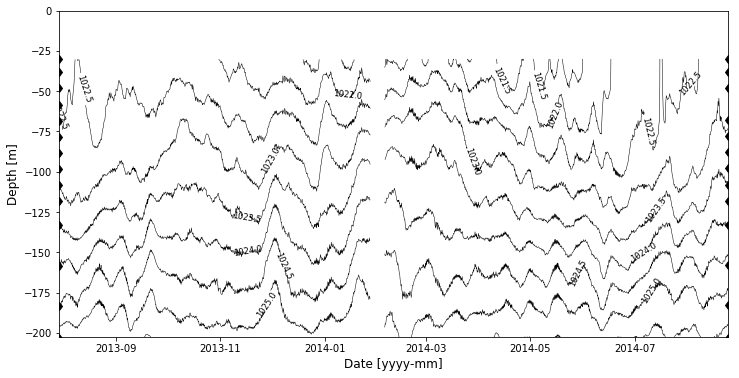

In [6]:
plt.figure(figsize=(12,6))
cf = plt.contour(time1, depths1, rho1.T, np.arange(1020,1030,0.5), colors='k', linewidths=0.5)
plt.clabel(cf, fmt='%3.1f', fontsize='small')

cf = plt.contour(time2, depths2, rho2.T, np.arange(1020,1030,0.5), colors='k', linewidths=0.5)
plt.clabel(cf, fmt='%3.1f', fontsize='small')

# Plot the instrument depths
nz = depths1.shape[0]
plt.plot([time1[0] for ii in range(nz)], depths1,'kd')
nz = depths2.shape[0]
plt.plot([time2[-1] for ii in range(nz)], depths2,'kd')


plt.ylim(zmin,0)
plt.ylabel('Depth [m]')
plt.xlabel('Date [yyyy-mm]')

plt.savefig('Density_zt_%s.pdf'%site)
plt.savefig('Density_zt_%s.png'%site)

# Nice plot of the double-tanh function






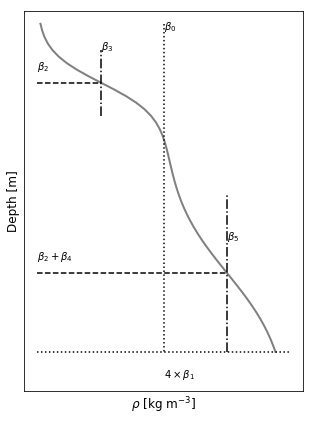

In [8]:
zout = np.arange(0,-255,-5.)

beta = [1022.,1.0, 45, 25, 145, 60]
rhotmp = double_tanh(beta, zout)

# Plot all of the beta
xlim = beta[0]
ylim = [zout[0], zout[-1]]

plt.figure(figsize=(5,7))
#plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.plot(rhotmp, zout,  '0.5', lw=2)

plt.ylim(ylim[1]-30, 10)
# beta_0
plt.plot([beta[0],beta[0]], ylim, 'k:')
plt.text(beta[0], ylim[0]-5, r'$\beta_0$')

# beta_1
plt.plot([beta[0]-2*beta[1],beta[0]+2*beta[1]], [ylim[1],ylim[1]], 'k:')
plt.text(beta[0], ylim[-1]-20, r'$4\times \beta_1$')

# beta_2
k2 = np.argwhere(zout<=-beta[2])[0][0]
plt.plot([beta[0]-2*beta[1], rhotmp[k2]],[-beta[2],-beta[2]], 'k--')
plt.text(beta[0]-2*beta[1], -beta[2]+10, r'$\beta_2$')

# beta_3
plt.plot([rhotmp[k2], rhotmp[k2]],[-beta[2]-beta[3],-beta[2]+beta[3]], 'k-.')
plt.text(rhotmp[k2], -beta[2]+beta[3], r'$\beta_3$')

# beta_4
z2 = -beta[2]-beta[4]
k2 = np.argwhere(zout<=z2)[0][0]
plt.plot([beta[0]-2*beta[1], rhotmp[k2]],[z2,z2], 'k--')
plt.text(beta[0]-2*beta[1], z2+10, r'$\beta_2+\beta_4$')

# beta_3
plt.plot([rhotmp[k2], rhotmp[k2]],[z2-beta[5],z2+beta[5]], 'k-.')
plt.text(rhotmp[k2], z2+beta[3], r'$\beta_5$')

plt.ylabel('Depth [m]')
plt.xlabel(r'$\rho$ [kg m$^{-3}$]')



plt.savefig('Double_tanh_schematic.pdf')
plt.savefig('Double_tanh_schematic.png')

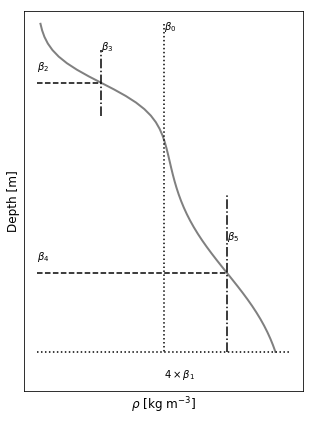

In [10]:
zout = np.arange(0,-255,-5.)

beta = [1022.,1.0, 45, 25, 145, 60]
rhotmp = double_tanh(beta, zout)

# Plot all of the beta
xlim = beta[0]
ylim = [zout[0], zout[-1]]

plt.figure(figsize=(5,7))
#plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.plot(rhotmp, zout,  '0.5', lw=2)

plt.ylim(ylim[1]-30, 10)
# beta_0
plt.plot([beta[0],beta[0]], ylim, 'k:')
plt.text(beta[0], ylim[0]-5, r'$\beta_0$')

# beta_1
plt.plot([beta[0]-2*beta[1],beta[0]+2*beta[1]], [ylim[1],ylim[1]], 'k:')
plt.text(beta[0], ylim[-1]-20, r'$4\times \beta_1$')

# beta_2
k2 = np.argwhere(zout<=-beta[2])[0][0]
plt.plot([beta[0]-2*beta[1], rhotmp[k2]],[-beta[2],-beta[2]], 'k--')
plt.text(beta[0]-2*beta[1], -beta[2]+10, r'$\beta_2$')

# beta_3
plt.plot([rhotmp[k2], rhotmp[k2]],[-beta[2]-beta[3],-beta[2]+beta[3]], 'k-.')
plt.text(rhotmp[k2], -beta[2]+beta[3], r'$\beta_3$')

# beta_4
z2 = -beta[2]-beta[4]
k2 = np.argwhere(zout<=z2)[0][0]
plt.plot([beta[0]-2*beta[1], rhotmp[k2]],[z2,z2], 'k--')
plt.text(beta[0]-2*beta[1], z2+10, r'$\beta_4$')

# beta_3
plt.plot([rhotmp[k2], rhotmp[k2]],[z2-beta[5],z2+beta[5]], 'k-.')
plt.text(rhotmp[k2], z2+beta[3], r'$\beta_5$')

plt.ylabel('Depth [m]')
plt.xlabel(r'$\rho$ [kg m$^{-3}$]')



plt.savefig('Double_tanh_schematic_v2.pdf')
plt.savefig('Double_tanh_schematic_v2.png')